# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [1]:
%matplotlib notebook
import sys
import os
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt
from geopandas import GeoDataFrame
from datetime import datetime
import datetime
from rasterio.plot import show
import Footprint_Processing as FP
import importlib
importlib.reload(FP)
# print('Kitty')

<module 'Footprint_Processing' from 'C:\\Users\\wesle\\FishIsland_Processing\\Footprint_Processing.py'>

# Date Range & Paramters
## Read & filter the data, initialize the Basin Map

In [7]:
DateRange=['2017-6-12 12:00:00','2017-9-14 23:30:00']
# DateRange=['2017-7-11 02:00:00','2017-7-11 03:30:00']  ## Subset for testing
Axis = 35
rs = [.5,.9,.95,.98,.99]#[.1,.25,.5,.75,.8,.9,.95]#,75,90]
Width = 500#2000#
dx = 1#10#
nx = int(Width/dx)
# nx = 250
# XY = [503675.880,7695880.205]
# XY = [504675.1,7695880.94]
XY = [504679.22, 7695885.48]
XY = [504679.36, 7695885.74]
 
fp_params={'dx':dx,'nx':nx,'rs':rs}
thresh=.05

RasterPath = 'C:/FishIsland_2017/Footprints/'
DataName = 'C:/FishIsland_2017/AllData.csv'
# DataName = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AllData.csv'
DataName = 'MostRecent.csv'

# BL = pd.read_csv('C:/FishIsland_2017/BL_Data/PBLH_GFS.csv')
# BL = BL.set_index(pd.DatetimeIndex(BL.datetime))
    
    
Data = pd.read_csv(DataName)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))

# print(Data.index,BL.index)

# # Data = merge=pd.merge(Data,BL, how='inner', left_index=True, right_index=True)
# print(Data.columns)

Data['Run']=0
Data['Zm'] = 2.87
Data['Z_L'] = Data['Zm']/Data['L']

# fig,ax = plt.subplots(figsize = (8,10))
diff = []
# for b in [1,0]:
Data['canopy_height'] = (Data['Canopy_Height_2']*.67+Data['Canopy_Height_1']*(.33))*.01
Data['canopy_height'] = Data['canopy_height'].bfill()
Data['Zo'] = Data['canopy_height']*.15
Data['d']=Data['canopy_height']*.66
Data['Zm']=Data['Zm']-Data['d']
Data['Z_L'] = Data['Zm']/Data['L']
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])
Data.loc[(Data['Z_L']<-thresh)|(Data['Z_L']>thresh),['Z0']]=np.nan
Data.loc[(Data['wind_speed']<1.5),['Z0']]=np.nan
diff.append(Data['Z0'].values.copy())
Daily = Data.resample('D').median()
Data['Ratio'] = Data['u*']/Data['wind_speed']
#     print(Data.loc[Data['Z0']>.5,['u*','wind_speed','wind_dir','Z0','Ratio']])
Wind_Groups_median = Data.groupby(['Dir']).median()
Wind_Groups_std = Data.groupby(['Dir']).std()
Wind_Groups_Ct = Data.groupby(['Dir']).count()
Wind_Groups_CI = Wind_Groups_std/Wind_Groups_Ct**.5*1.96


print(Data['Zo'])


Wind_Groups_median['Dir'] = Wind_Groups_median.index*np.pi/180


Data.loc[(np.isfinite(Data['Zo'])==True)&#np.isfinite(Data['co2_flux'])==True)&
         (Data['u*']>.1)&
         (Data.index>DateRange[0])&
         (Data.index<DateRange[1])&              # Run a subset for teting
     ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
     ['Run']]=1

try:
    Data = Data.drop(['datetime'],axis=1)
except:pass
Run = Data.loc[Data['Run']==1].reset_index()#.drop(['index'],axis=1)
Runs = Run.shape[0]
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)
print(Transform)
print(west,north)

datetime
2017-06-23 00:00:00-06:00    0.017552
2017-06-23 00:30:00-06:00    0.017552
2017-06-23 01:00:00-06:00    0.017552
2017-06-23 01:30:00-06:00    0.017552
2017-06-23 02:00:00-06:00    0.017552
                               ...   
2017-09-13 10:30:00-06:00    0.030045
2017-09-13 11:00:00-06:00    0.030045
2017-09-13 11:30:00-06:00    0.030045
2017-09-13 12:00:00-06:00    0.030045
2017-09-13 12:30:00-06:00         NaN
Name: Zo, Length: 3962, dtype: float64
| 1.00, 0.00, 504429.36|
| 0.00,-1.00, 7696135.74|
| 0.00, 0.00, 1.00|
504429.36 7696135.74


In [8]:
Data.loc[#(np.isfinite(Data['Zo'])==True)&#np.isfinite(Data['co2_flux'])==True)&
#          (Data['u*']>.1)&
#          (Data.index>DateRange[0])&
#          (Data.index<DateRange[1])&              # Run a subset for teting
     ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
        ]
# print(Data['Zo'])

,DOY,file_records,used_records,Tau,qc_Tau,rand_err_Tau,H,qc_H,rand_err_H,LE,...,Delta_VWC_2,fco2,fch4,ER,Zm,Z0,Run,Z_L,canopy_height,d
datetime,,,,,,,,,,,,,,,,,,,,,
2017-06-23 00:00:00-06:00,174,1800.0,1800.0,0.073630,0.0,NaN,6.368283,1.0,NaN,12.286230,...,0.000000,-0.101038,0.023772,NaN,2.792771,0.011149,1,-0.014109,0.117014,0.077229
2017-06-23 00:30:00-06:00,174,1800.0,1800.0,0.074988,0.0,NaN,-17.662798,0.0,NaN,2.259226,...,0.000000,0.561228,0.022941,NaN,2.792771,0.008530,1,0.038239,0.117014,0.077229
2017-06-23 01:00:00-06:00,174,1800.0,1800.0,0.108962,0.0,NaN,-11.517344,0.0,NaN,1.372132,...,0.000000,0.673105,0.025634,NaN,2.792771,0.008029,1,0.014341,0.117014,0.077229
2017-06-23 01:30:00-06:00,174,1800.0,1800.0,0.084511,0.0,NaN,-9.591518,0.0,NaN,NaN,...,0.002540,0.506380,0.025041,NaN,2.792771,0.006169,1,0.017562,0.117014,0.077229
2017-06-23 02:00:00-06:00,174,1800.0,1800.0,0.070018,0.0,NaN,-8.110602,0.0,NaN,1.213447,...,0.004741,0.490812,0.024376,NaN,2.792771,0.006291,1,0.019708,0.117014,0.077229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-13 10:00:00-06:00,256,18000.0,18000.0,0.151011,0.0,NaN,-14.370780,0.0,NaN,1.361470,...,0.007363,0.027651,0.019229,NaN,2.737802,0.007796,1,0.010474,0.200300,0.132198
2017-09-13 10:30:00-06:00,256,18000.0,18000.0,0.108859,0.0,NaN,-10.124663,0.0,NaN,1.375797,...,0.007015,-0.154846,0.014945,NaN,2.737802,0.011142,1,0.012063,0.200300,0.132198
2017-09-13 11:00:00-06:00,256,18000.0,18000.0,0.105301,0.0,NaN,NaN,2.0,NaN,2.202770,...,0.006599,-0.267946,0.013951,NaN,2.737802,0.007345,1,0.002424,0.200300,0.132198


In [9]:

# fig,ax=plt.subplots(1,1,figsize = (8,8))

with rasterio.open('Site_Image.tif','w+',driver='GTiff',width = nx+1, height = nx+1,
                   count = 1,dtype=np.float64,transform = Transform,crs = ({'init': 'EPSG:32608'})) as out:
#     print(out.read(1))
# with rasterio.open('Site_Image.tif','r',driver='GTiff',width = nx+1, height = nx+1,
#                    count = 1,dtype=np.float64,affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    print(XY)
    print(params)
#     show(out.read([1]),transform=out.profile['transform'],ax=ax)
    bounds = (out.bounds)
from shapely.geometry import box
geom = box(*bounds)
df = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
df.to_file('C:/FishIsland_2017/SiteInfo/Classification/boundary.shp')

[504679.36, 7695885.74]
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 501, 'height': 501, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(1.0, 0.0, 504429.36,
       0.0, -1.0, 7696135.74), 'tiled': False, 'interleave': 'band'}


## Footprints

In [10]:
import fiona 
import geopandas as gpd

# Get all the layers from the .gdb file  = 
gdb_file = 'C:\FishIsland_2017\SiteInfo\Classification\Classification.gdb'
layers = fiona.listlayers(gdb_file)

gdf = gpd.read_file(gdb_file,layer='LandscapeClass_250_Dissolve')
gdf['Class']=gdf['FIRST_Class']
gdf.loc[gdf['Id']==1,'FIRST_Class']='Polygon'
gdf.loc[gdf['Id']==1,'Id']=2
gdf['Pct'] = gdf['Shape_Area']/gdf['Shape_Area'].sum()
    # Do stuff with the gdf
# print(gdf.groupby('Id').sum())
# print(gdf.groubp)

# for layer in layers:
gdf = gpd.read_file(gdb_file,layer='LandscapeClass_150_Dissolve')
gdf['Class']=gdf['FIRST_Class']
gdf['Pct'] = gdf['Shape_Area']/gdf['Shape_Area'].sum()*100
    # Do stuff with the gdf
print(gdf[['Class','Pct']])

       Class        Pct
0   Collapse   4.520636
1    Polygon  62.578517
2  Disturbed   0.087387
3        Rim  32.813460


<IPython.core.display.Javascript object>


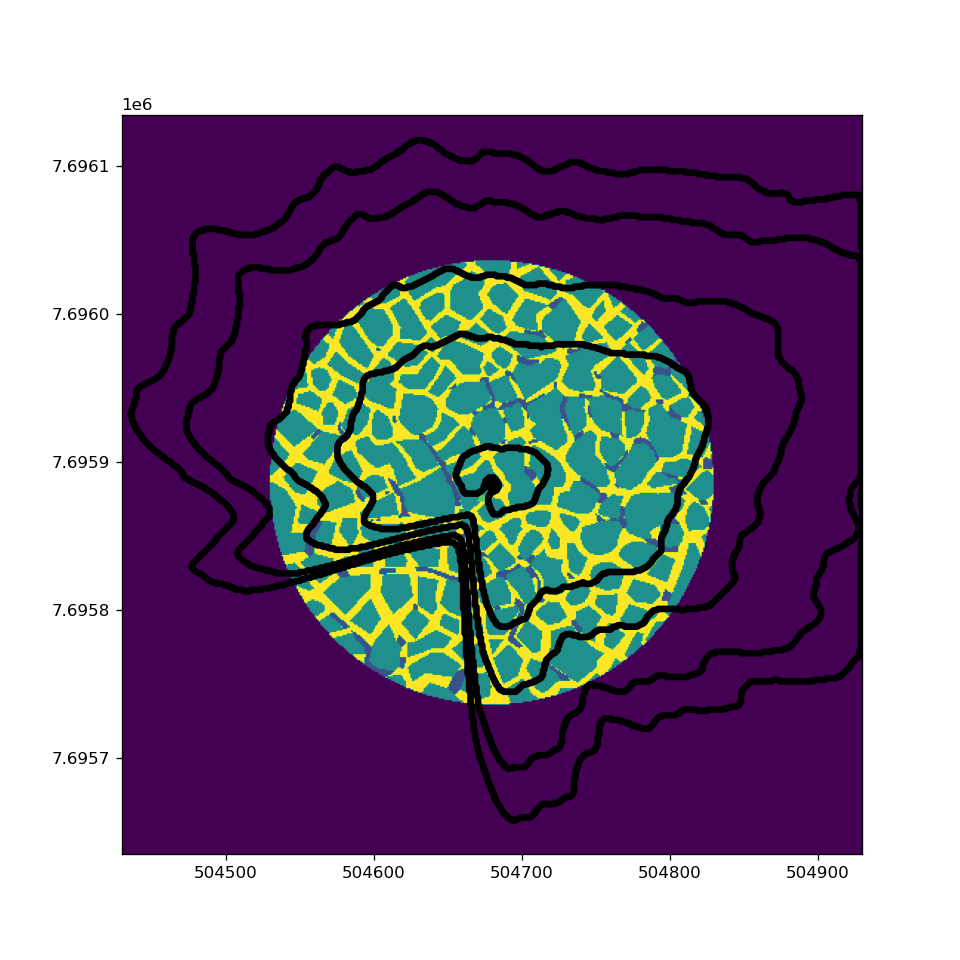

| 1.00, 0.00, 504429.36|
| 0.00,-1.00, 7696135.74|
| 0.00, 0.00, 1.00|
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 501, 'height': 501, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(1.0, 0.0, 504429.36,
       0.0, -1.0, 7696135.74), 'tiled': False, 'interleave': 'band'}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 501, 'height': 501, 'count': 1, 'crs': CRS.from_dict(init='epsg:32608'), 'transform': Affine(1.0, 0.0, 504429.36,
       0.0, -1.0, 7696135.74), 'tiled': False, 'interleave': 'band'}
1.0
   contour                                           geometry           area
0     0.50  POLYGON ((504655.859 7695889.605, 504655.779 7...    1904.551722
1     0.9

In [11]:

fig,ax=plt.subplots(1,1,figsize = (8,8))
with rasterio.open('C:/FishIsland_2017/odm_orthophoto.tif','r',**params) as Im:
    show(Im.read([1,2,3,4]),transform=Im.profile['transform'],ax=ax)

    
# fig,ax=plt.subplots(1,1,figsize = (10,10))
# with rasterio.open('C:\\FishIsland_2017\\Footprints/Climatology.tiff','r',**params) as Im:
#     show(Im.read([1]),transform=Im.profile['transform'],ax=ax)
print(params['transform'])


# LC = gpd.read_file('C:/FishIsland_2017/SiteInfo/LandscapeClass_Dissolved.shp')
# LC['Id']=LC['MEAN_MEAN_']
# LC = LC.dissolve(by='Id').reset_index()
LC = gdf
# LC.plot(ax=ax)


shapes = ((geom,value) for geom,value in zip(LC['geometry'],LC['Id']))
# print(shapes)
with rasterio.open('Site_Image.tif','w+',**params) as out:
    out_arr = out.read(1)
    params = out.profile
    print(params)
    Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = Transform,default_value=0)
    print(Image)
    out.write(Image,1)
#     ax.imshow(Image)


with rasterio.open('Site_Image.tif','r') as Im:
    show(Im.read([1]),transform=Im.profile['transform'],ax=ax)
#     print()
    Vals = Im.read(1)
# print(Vals)


Go = True
if Go == True:
    importlib.reload(FP)
    Domain = os.getcwd()+'/Site_Image.tif'
    FP_Data = FP.Calculate(RasterPath,Run,Domain,XY,params,Classes=LC,ax=ax,
                           nx=nx,dx=dx,rs=rs,OtherClass='FarField')
    
    
    Data = Data.merge(FP_Data.Intersections,left_on='datetime', right_on='datetime', how='outer')

#     Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')
#     Data.to_csv('Data_Footprints_'+str(datetime.datetime.now()).split(' ')[0]+'.csv')


In [12]:
# print(LC.columns)
# print(FP_Data.)
FP_Data.fpf.max()

# print(Data.columns)
# print(Data[['Rim','Polygon','Collapse','Disturbed','FarField','ch4_flux','co2_flux']].corr())

0.006997653253147127

In [ ]:
T1 = Data.loc[np.isnan(Data['fco2'])==False,['Polygon','Rim','Collapse','Disturbed','FarField']].describe().round(3)

T2 = Data.loc[np.isnan(Data['fch4'])==False,['Polygon','Rim','Collapse','Disturbed','FarField']].describe().round(3)

print(T1)
print(T1-T2)